In [42]:
# wtf happened to this file and why doesn't the torch dataloader find it?
# audiopath = "/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ027-0028_22k_normalized.wav"
# pitchpath = "/usr/src/app/radtts/data_cache/lj_data_LJSpeech-1.1_wavs_LJ027-0028_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt"


# audiopath = "/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ044-0174_22k_normalized.wav"
# pitchpath = "/usr/src/app/radtts/data_cache/lj_data_LJSpeech-1.1_wavs_LJ044-0174_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt"
import os
use_log_f0 = 0
audiopath = "/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ003-0239_22k_normalized.wav"
# pitchpath = "/usr/src/app/radtts/data_cache/lj_data_LJSpeech-1.1_wavs_LJ003-0239_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt"
filename = '_'.join(audiopath.split('/')[-4:])
betabinom_cache_path = "/usr/src/app/radtts/data_cache"
f0_path = os.path.join(betabinom_cache_path, filename)
f0_path += "_f0_sr{}_fl{}_hl{}_f0min{}_f0max{}_log{}.pt".format(
    sampling_rate, filter_length, hop_length,
    data_config['f0_min'], data_config['f0_max'], use_log_f0)

In [5]:
import pandas as pd
data = pd.read_csv('/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/metadata_formatted_full_pitch.txt', sep = '|', index_col = None,header = None)

In [49]:
audiopaths = data[0]
for audiopath in audiopaths:
    
    filename = '_'.join(audiopath.split('/')[-4:])
    betabinom_cache_path = "/usr/src/app/radtts/data_cache"
    f0_path = os.path.join(betabinom_cache_path, filename)
    f0_path += "_f0_sr{}_fl{}_hl{}_f0min{}_f0max{}_log{}.pt".format(
        sampling_rate, filter_length, hop_length,
        data_config['f0_min'], data_config['f0_max'], use_log_f0)    
    
    if not os.path.exists(f0_path):
        print(f0_path)
        audio, sampling_rate = load_wav_to_torch(audiopath)
        f0, voiced_mask, p_voiced = get_f0_pvoiced(audio.cpu().numpy(), sampling_rate=sampling_rate, frame_length=filter_length,
                           hop_length=hop_length, f0_min=mel_fmin, f0_max=mel_fmax)
        torch.save({'f0': f0,
                    'voiced_mask': voiced_mask,
                    'p_voiced': p_voiced}, f0_path)

/usr/src/app/radtts/data_cache/lj_data_LJSpeech-1.1_wavs_LJ005-0094_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/lj_data_LJSpeech-1.1_wavs_LJ040-0007_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt


In [9]:
from librosa import pyin
from uberduck_ml_dev.exec.train_radtts_with_ray import data_config, load_wav_to_torch
filter_length=data_config['filter_length']
hop_length=data_config['hop_length']
win_length=data_config['win_length']
sampling_rate=22050
n_mel_channels=data_config['n_mel_channels']
f0_min=data_config['f0_min']
f0_max=data_config['f0_max']

In [48]:
max_wav_value = 32768.

def get_f0_pvoiced(audio, sampling_rate=22050, frame_length=1024,
                   hop_length=256, f0_min=100, f0_max=300):

    audio_norm = audio / max_wav_value
    f0, voiced_mask, p_voiced = pyin(
        audio_norm, f0_min, f0_max, sampling_rate,
        frame_length=frame_length, win_length=frame_length // 2,
        hop_length=hop_length)
    f0[~voiced_mask] = 0.0
    f0 = torch.FloatTensor(f0)
    p_voiced = torch.FloatTensor(p_voiced)
    voiced_mask = torch.FloatTensor(voiced_mask)
    return f0, voiced_mask, p_voiced

In [36]:
import torch
audio, sampling_rate = load_wav_to_torch(audiopath)
f0, voiced_mask, p_voiced = get_f0_pvoiced(audio.cpu().numpy(), sampling_rate=sampling_rate, frame_length=filter_length,
                   hop_length=hop_length, f0_min=f0_min, f0_max=f0_max)

In [37]:
torch.save({'f0': f0,
            'voiced_mask': voiced_mask,
            'p_voiced': p_voiced}, pitchpath)

In [13]:
sampling_rate

22050

In [3]:
resnet_se_model = '/usr/src/app/radtts/resnet_se.pth.tar'
resnet_se_config = '/usr/src/app/radtts/resnet_se_config.json'

import torch
import json
with open(resnet_se_config) as f:
    resnet_config =json.load(f)
    
state_dict = torch.load(resnet_se_model)['model']

audio_config = dict(resnet_config["audio"])
model_params = resnet_config["model_params"]
if "model_name" in model_params:
    del model_params["model_name"]

audio_config["sample_rate"] = 22050
from TTS.encoder.models.resnet import ResNetSpeakerEncoder
model = ResNetSpeakerEncoder(**model_params, audio_config=audio_config)
model.eval()
model.cuda()

ResNetSpeakerEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=32, bias=True)
          (3): Sigmoid()
        )
      )
    )
    (1): SEBasicBlo

In [9]:
#audioemb

# data
model.eval()
model.cuda()

from scipy.io.wavfile import read
from tqdm import tqdm
embs = []
audio_datas = [read(path)[1] for path in data[0]]
with torch.no_grad():
    for audio_data in tqdm(audio_datas):
        datum = torch.FloatTensor(audio_data).unsqueeze(-1).t().cuda()
        embs.append(model(datum))

100%|██████████| 13097/13097 [02:19<00:00, 93.88it/s] 


In [16]:
import numpy as np
# embs = [emb.cpu().detach().numpy() for emb in embs]
embs = np.vstack(embs)

In [18]:
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=50)
t_svd.fit(embs)

TruncatedSVD(n_components=50)

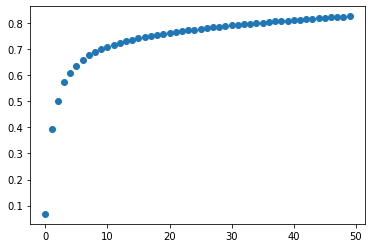

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(list(range(50)), np.cumsum(t_svd.explained_variance_ratio_))

In [8]:
embs[0].shape

torch.Size([1, 512])

In [12]:
help(torch.save)

Help on function save in module torch.serialization:

save(obj: object, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module: Any = <module 'pickle' from '/opt/conda/lib/python3.8/pickle.py'>, pickle_protocol: int = 2, _use_new_zipfile_serialization: bool = True) -> None
    save(obj, f, pickle_module=pickle, pickle_protocol=DEFAULT_PROTOCOL, _use_new_zipfile_serialization=True)
    
    Saves an object to a disk file.
    
    See also: :ref:`saving-loading-tensors`
    
    Args:
        obj: saved object
        f: a file-like object (has to implement write and flush) or a string or
           os.PathLike object containing a file name
        pickle_module: module used for pickling metadata and objects
        pickle_protocol: can be specified to override the default protocol
    
    .. note::
        A common PyTorch convention is to save tensors using .pt file extension.
    
    .. note::
        PyTorch preserves storage sharing across serialization. See
        :ref:

In [15]:
emb_paths = []
import os
for audiopath, emb in tqdm(zip(data[0], embs)):
    audiopaths = data[0]
    filename = '_'.join(audiopath.split('/')[-4:])
    cache_path = "/usr/src/app/radtts/data_cache"
    emb_path = os.path.join(cache_path, filename)
    emb_path += "_emb.pt"
    emb_paths.append(emb_path)
    torch.save(emb, emb_path)

13097it [00:02, 5882.62it/s]


In [18]:
data[4] = emb_paths

In [19]:
data.to_csv('/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/metadata_formatted_full_pitch_emb.txt', sep = '|', index = None, header= None)

In [1]:
embs[0]

NameError: name 'embs' is not defined

In [45]:
import pandas as pd
import os
import csv
use_log_f0 = 0
data = pd.read_csv('/usr/src/app/radtts/data/combined_022123_filelist_22k_normalized.txt', sep = '|', index_col = None,header = None,quoting=csv.QUOTE_NONE)
# ye preprocessing messup
shitty_indices =[]
audiopaths = data[0]
f0_paths = []
for i, audiopath in enumerate(audiopaths):
#     print(audiopath)
    filename = '_'.join(audiopath.split('/')[-4:])
    betabinom_cache_path = "/usr/src/app/radtts/data_cache"
    f0_path = os.path.join(betabinom_cache_path, filename)
    f0_path += "_f0_sr{}_fl{}_hl{}_f0min{}_f0max{}_log{}.pt".format(
        sampling_rate, filter_length, hop_length,
        data_config['f0_min'], data_config['f0_max'], use_log_f0)    
    f0_paths.append(f0_path)
    if not os.path.exists(f0_path):
        print(f0_path)
        audio, sampling_rate = load_wav_to_torch(audiopath)
        f0, voiced_mask, p_voiced = get_f0_pvoiced(audio.cpu().numpy(), sampling_rate=sampling_rate, frame_length=filter_length,
                           hop_length=hop_length, f0_min=mel_fmin, f0_max=mel_fmax)
        torch.save({'f0': f0,
                    'voiced_mask': voiced_mask,
                    'p_voiced': p_voiced}, f0_path)
        
    if audiopath[:4] !='/usr':
        shitty_indices.append(i)

In [46]:
shitty_indices

[2185,
 2186,
 2187,
 2188,
 2189,
 2190,
 2191,
 2192,
 2193,
 2194,
 2195,
 2196,
 2197,
 2198,
 2199,
 2200,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2213,
 2214,
 2215,
 2216,
 2217,
 2218,
 2219,
 2220,
 2221,
 2222,
 2223,
 2224,
 2225,
 2226,
 2227,
 2228,
 2229,
 2230,
 2231,
 2232,
 2233,
 2234,
 2235,
 2236,
 2237]

In [48]:
data[3] = f0_paths
data = data.drop(shitty_indices)

In [50]:
for i, audiopath in enumerate(data[0]):
    if audiopath[:4] !='/usr':
        print(i)

In [51]:

data.to_csv('/usr/src/app/radtts/data/30_decoder_pitch.txt', sep = '|', index = None, header= None,quoting=csv.QUOTE_NONE)

In [34]:
print(len(f0_paths))

21802


In [35]:
print(len(audiopaths))

21802


In [31]:
audiopaths = data[3]
for audiopath in audiopaths:
    if 'kanye' in audiopath:
#         print(audiopath.split('kanye-rap')[0])
#         if audiopath.split('kanye-rap')[0] != '/usr/src/app/radtts/data/':
#             print(audiopath)
        print(audiopath)

/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-1_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-2_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-3_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-4_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-5_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-6_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-7_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data_cache/data_kanye-rap_wavs_kanye-8_22k_normalized.wav_f0_sr

In [28]:
# import numpy as np
# MAX_WAV_VALUE=32768
# from scipy.io.wavfile import write, read
# from tqdm import tqdm
# import librosa
# output_paths =[]
# for rel_path in tqdm(full_data[0]):
#     if rel_path[:7] == 'dataset':
#         rel_uuid = rel_path.split('.wav')[-2]
#         in_path = f"/usr/src/app/radtts/data/{rel_path}"
#         output_path = f"/usr/src/app/radtts/data/{rel_uuid}_22k_normalized.wav"
#         resample(in_path, output_path)
#         output_paths.append(output_path)
#     else:
#         rel_uuid = rel_path.split('.wav')[-2]
#         output_path = f"/usr/src/app/radtts/data/{rel_uuid}_22k_normalized.wav"
#         output_paths.append(output_path)

In [29]:
data = pd.read_csv('/usr/src/app/radtts/data/30_decoder_pitch.txt', sep = '|', index_col = None,header = None)


In [12]:
f0_paths

['/usr/src/app/radtts/data_cache/data_TAG_wavs_1_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_2_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_3_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_4_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_5_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_6_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_7_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/radtts/data_cache/data_TAG_wavs_8_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt',
 '/usr/src/app/r

In [15]:
data[0]

0        /usr/src/app/radtts/data/TAG/wavs/1_22k_normal...
1        /usr/src/app/radtts/data/TAG/wavs/2_22k_normal...
2        /usr/src/app/radtts/data/TAG/wavs/3_22k_normal...
3        /usr/src/app/radtts/data/TAG/wavs/4_22k_normal...
4        /usr/src/app/radtts/data/TAG/wavs/5_22k_normal...
                               ...                        
21797    /usr/src/app/radtts/data/Po_Data/wavs/231_22k_...
21798    /usr/src/app/radtts/data/Po_Data/wavs/232_22k_...
21799    /usr/src/app/radtts/data/Po_Data/wavs/233_22k_...
21800    /usr/src/app/radtts/data/Po_Data/wavs/234_22k_...
21801    /usr/src/app/radtts/data/Po_Data/wavs/235_22k_...
Name: 0, Length: 21802, dtype: object